<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Lab_2/Sesi%C3%B3n%202/Laboratorio_II_Sesion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021



## Objetivos

*   Analizar problemas con variables de salida multietiqueta.
*   Realizar la arquitectura de una Red Neuronal Artificial.
*   Integrar una ANN básica junto a un Pipeline y un GridSearch.



## Primer Problema
<p style="text-align: justify;"> El Internet de las Cosas (IoT) está desempeñando un papel cada vez más importante en nuestras actividades cotidianas, al habilitar la conexión de los objetos que nos rodean con servicios digitales. 
 
Últimamente, IoT se ha visto afectado por una variedad de botnets, los cuales intentan explotar vulnerabilidades en los protocolos de aplicación que interactúan directamente con los sistemas, provocando violaciones de seguridad. 
 
 Una solución a este tipo de ataques es identificar, de manera automática, eventos maliciosos contra los protocolos de comunicación. En este sentido, ***se desea desarrollar un sistema de detección de intrusos que permita una identificación temprana de estas amenazas***. Además, el Departamento de Seguridad le ha pedido que pueda clasificar los diferentes tipos de ataques. Con el fin de poder establecer los protocolos correspondientes y poder mitigar o recuperar el sistema en caso de ataque. 

</p>

### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install --upgrade scikit-learn

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [2]:
import pandas as pd
import numpy as np
import glob
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [3]:
url = 'https://raw.githubusercontent.com/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/main/Lab_2/Sesi%C3%B3n%202/train.csv'
train = pd.read_csv(url)
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal


#### Entendimiento de los Datos


In [4]:
ProfileReport(train, minimal= True)

Summarize dataset:   0%|          | 0/52 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 3. Preparación de datos

Primero, dividiremos nuestros atributos o variables de entrada. Y estableceremos como variables de salida, la cantidad de salidas que tenemos para este problema.

In [5]:
X_train = train.drop(['id','attack_cat'],axis=1)
X_train.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0


In [6]:
transf = OneHotEncoder(handle_unknown='ignore')
y_train = transf.fit_transform(train[['attack_cat']])
onehot = pd.DataFrame(y_train.toarray(),columns=transf.categories_[0].tolist())
onehot[onehot['DoS'] == 1]

,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms
246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
65741,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65757,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65775,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65779,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Modelamiento

Primero, estableceremos un modelo base. para ello, crearemos una **MLP** con los valores que vienen por defecto, y lo integraremos a nuestro pipeline. Importante destacar que, vamos a cambiar nuestra función de activación, dado que queremos que nuestro rango de salida sea ente [0,1]. 

In [7]:
ct = ColumnTransformer([
       ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
       make_column_selector(dtype_include=np.object)),
       ], remainder='passthrough')

estimators = [
              ('encoder', ct),
              ('normalize',MaxAbsScaler()),
              ('clf', MLPRegressor(hidden_layer_sizes=100,random_state=33,activation='logistic')),
              ]
pipe = Pipeline(estimators)
pipe.fit(X_train,y_train.toarray())

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f197bb5a510>)])),
                ('normalize', MaxAbsScaler()),
                ('clf',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=100,
                              random_state=33))])

In [8]:
y_pred = pd.DataFrame(pipe.predict(X_train),columns=onehot.columns)
display(y_pred)
y_pred = np.argmax(pipe.predict(X_train), axis=1)

,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms
0,-0.007396,-0.000314,0.115943,0.218004,0.081955,0.025734,0.285804,0.231121,0.016155,0.003635
1,-0.020528,-0.011263,0.038366,0.186838,0.199139,0.117385,0.432674,0.033849,0.003404,0.007319
2,-0.013524,-0.003628,0.070902,0.164316,0.164971,0.077939,0.440313,0.074941,0.003285,0.005290
3,-0.007662,0.001362,0.084422,0.175970,0.150899,0.074930,0.398981,0.094853,0.003091,0.004417
4,-0.022038,-0.017662,0.012598,0.139119,0.228155,0.110128,0.536262,-0.014471,-0.000360,0.006762
...,...,...,...,...,...,...,...,...,...,...
82327,-0.005757,-0.004283,0.141052,0.223127,0.018804,-0.038466,0.267943,0.333833,0.027117,0.003097
82328,-0.013380,0.003895,-0.007755,0.231359,0.217308,0.021669,0.519218,0.016494,0.001028,0.004086
82329,-0.019697,-0.008110,-0.039450,0.048035,-0.006320,0.015769,0.990003,0.007607,-0.012569,0.004725
82330,-0.019697,-0.008111,-0.039450,0.048034,-0.006318,0.015770,0.990001,0.007607,-0.012569,0.004725


### 5. Validación

Creamos una función que nos permite graficar la matriz de confusión.

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Debido a que este es un problema de clasificación, en donde vamos a determinar el tipo de ataque. Tendremos que seleccionar una variable basado en sus valores. Dado que la codificación que usamos, se estabece un rango entre [0,1], estableceremos la selección del ataque como el valor más alto de todas estas variables de salida.

Confusion matrix, without normalization


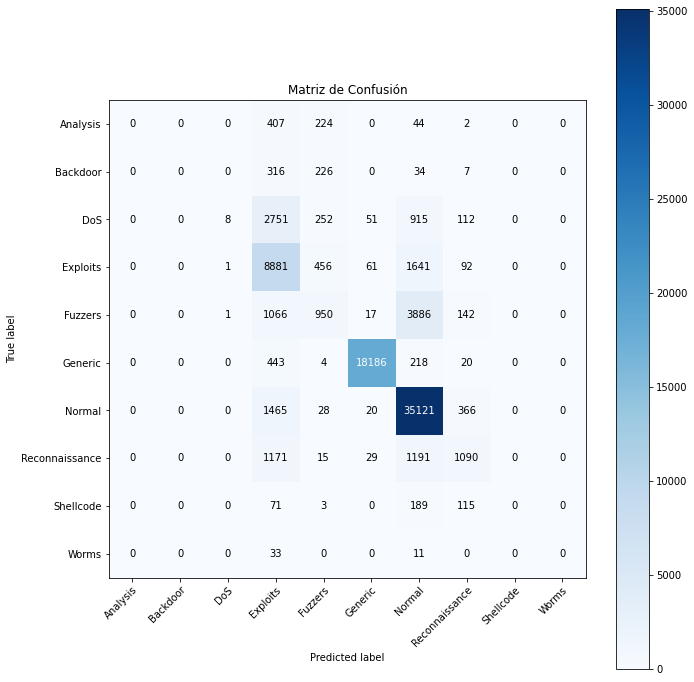

In [10]:
y_train_un=np.argmax(y_train, axis=1)
plot_confusion_matrix(y_true=y_train_un, y_pred=y_pred, classes=onehot.columns,
                      title='Matriz de Confusión')

In [11]:
print(classification_report(y_train_un, y_pred, target_names=onehot.columns))

                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.00      0.00      0.00       583
           DoS       0.80      0.00      0.00      4089
      Exploits       0.53      0.80      0.64     11132
       Fuzzers       0.44      0.16      0.23      6062
       Generic       0.99      0.96      0.98     18871
        Normal       0.81      0.95      0.88     37000
Reconnaissance       0.56      0.31      0.40      3496
     Shellcode       0.00      0.00      0.00       378
         Worms       0.00      0.00      0.00        44

      accuracy                           0.78     82332
     macro avg       0.41      0.32      0.31     82332
  weighted avg       0.76      0.78      0.74     82332



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4. Modelamiento

#### Búsqueda de hiperparámetros

Dado que las Redes neuronales tienen varios hiperparámetros que podemos entonar, Se realizará esta búsqueda a través de Grid Search, junto a otros hiperparámetros dentro del Pipeline que construimos. 

In [12]:
def multiple_recall(y_true,y_pred,average='binary'):
    yt =  np.argmax(y_true, axis=1)
    yp =  np.argmax(y_pred, axis=1)
    return recall_score(yt,yp,average=average,zero_division=0)

new_score = make_scorer(multiple_recall, average='weighted')

estimators = [
              ('encoder', ct),
              ('normalize',MaxAbsScaler()),
              ('clf', MLPRegressor(hidden_layer_sizes=100,random_state=33,activation='logistic')),
              ]
pipe = Pipeline(estimators)

param_grid = dict(encoder__encoder=[OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), OneHotEncoder(handle_unknown='ignore')],
                  normalize=['passthrough', MaxAbsScaler()],
                  clf__hidden_layer_sizes= [100,200,50],
                  clf__activation= ['identity', 'logistic', 'tanh', 'relu'],
                  )

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3,scoring=new_score,n_jobs=-1)

grid_search.fit(X_train,y_train.toarray())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f197bb5a510>)])),
                                       ('normalize', MaxAbsScaler()),
                                       ('clf',
                                        MLPRegressor(activation='logistic',
                                                     hidd...
             n_jobs=-1,
             param_grid={'clf__activation': ['identity', 'logistic', 'tanh',
               

In [13]:
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_search.best_estimator_

0.7664455736629965
{'clf__activation': 'relu', 'clf__hidden_layer_sizes': 200, 'encoder__encoder': OneHotEncoder(handle_unknown='ignore'), 'normalize': MaxAbsScaler()}


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f197b9593d0>)])),
                ('normalize', MaxAbsScaler()),
                ('clf', MLPRegressor(hidden_layer_sizes=200, random_state=33))])

### 5. Validación

Revisamos el rendimiento, esta vez de el mejor modelo encontrado por GridSearch.

In [15]:
y_pred = pd.DataFrame(grid_search.best_estimator_.predict(X_train),columns=onehot.columns)
display(y_pred)
y_pred = np.argmax(grid_search.best_estimator_.predict(X_train), axis=1)

,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms
0,0.000352,-0.023992,0.064427,0.055637,-0.002716,0.016483,0.681098,0.130372,0.042695,-0.003194
1,-0.002106,-0.019549,0.048736,0.083044,0.086456,0.085868,0.749857,-0.067995,-0.007234,-0.000902
2,0.001541,-0.013954,0.014648,-0.018350,0.016866,0.043077,0.946041,-0.027698,0.011328,-0.006934
3,0.001065,-0.014885,0.013792,-0.017924,0.034566,0.023173,0.919377,-0.007614,0.017508,-0.004893
4,0.008542,-0.013999,0.029878,0.035679,0.142374,0.036234,0.816793,-0.056254,-0.021680,0.000262
...,...,...,...,...,...,...,...,...,...,...
82327,-0.015930,-0.021194,0.043524,-0.099356,-0.127707,-0.021968,0.531019,0.631024,0.024886,-0.004824
82328,-0.007596,-0.003694,0.042083,0.253896,0.259109,-0.024261,0.511887,-0.023509,-0.021801,0.006883
82329,-0.016460,-0.011894,0.009714,0.008852,-0.019572,0.002438,0.987693,-0.002751,-0.009174,0.000271
82330,-0.016458,-0.011894,0.009712,0.008846,-0.019567,0.002440,0.987694,-0.002751,-0.009175,0.000271


Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.00      0.00      0.00       583
           DoS       0.45      0.53      0.49      4089
      Exploits       0.64      0.74      0.69     11132
       Fuzzers       0.76      0.56      0.64      6062
       Generic       0.99      0.97      0.98     18871
        Normal       0.93      0.98      0.95     37000
Reconnaissance       0.66      0.56      0.61      3496
     Shellcode       0.00      0.00      0.00       378
         Worms       0.00      0.00      0.00        44

      accuracy                           0.85     82332
     macro avg       0.44      0.43      0.44     82332
  weighted avg       0.84      0.85      0.84     82332



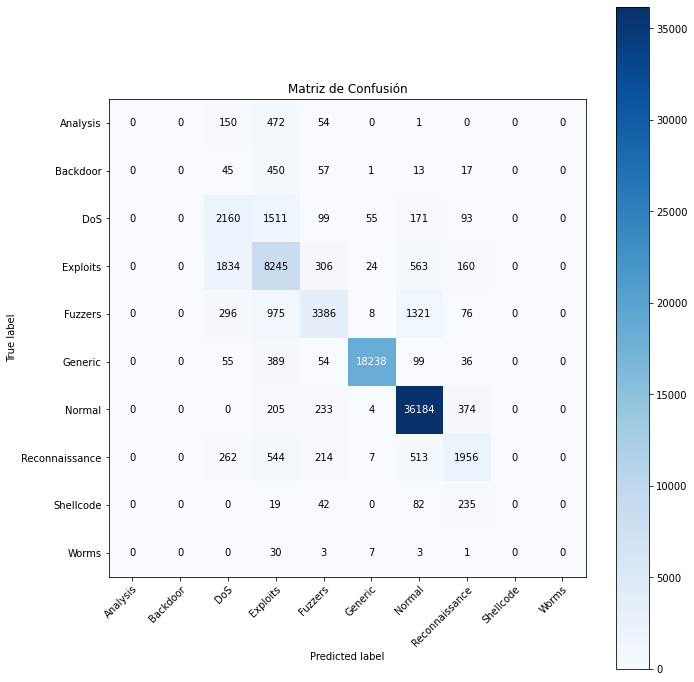

In [16]:
plot_confusion_matrix(y_true=y_train_un, y_pred=y_pred, classes=onehot.columns,
                      title='Matriz de Confusión')

print(classification_report(y_train_un, y_pred, target_names=onehot.columns))

### 6. Despliegue

Para comparar ya nuestro modelo en producción. Se realiza la evaluación en el conjunto de test y se construye la matriz de confusión.

In [23]:
url = 'https://raw.githubusercontent.com/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/main/Lab_2/Sesi%C3%B3n%202/test.csv'
test = pd.read_csv(url)

X_test = test.drop(['id','attack_cat'],axis=1)
y_test = transf.transform(test[['attack_cat']])

model = grid_search.best_estimator_
y_pred = np.argmax(model.predict(X_test), axis=1)
model

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f197b9593d0>)])),
                ('normalize', MaxAbsScaler()),
                ('clf', MLPRegressor(hidden_layer_sizes=200, random_state=33))])

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00      2000
      Backdoor       0.00      0.00      0.00      1746
           DoS       0.34      0.69      0.45     12264
      Exploits       0.74      0.59      0.65     33393
       Fuzzers       0.47      0.05      0.09     18184
       Generic       0.99      0.98      0.99     40000
        Normal       0.73      0.98      0.84     56000
Reconnaissance       0.75      0.47      0.58     10491
     Shellcode       0.00      0.00      0.00      1133
         Worms       0.00      0.00      0.00       130

      accuracy                           0.73    175341
     macro avg       0.40      0.38      0.36    175341
  weighted avg       0.72      0.73      0.69    175341



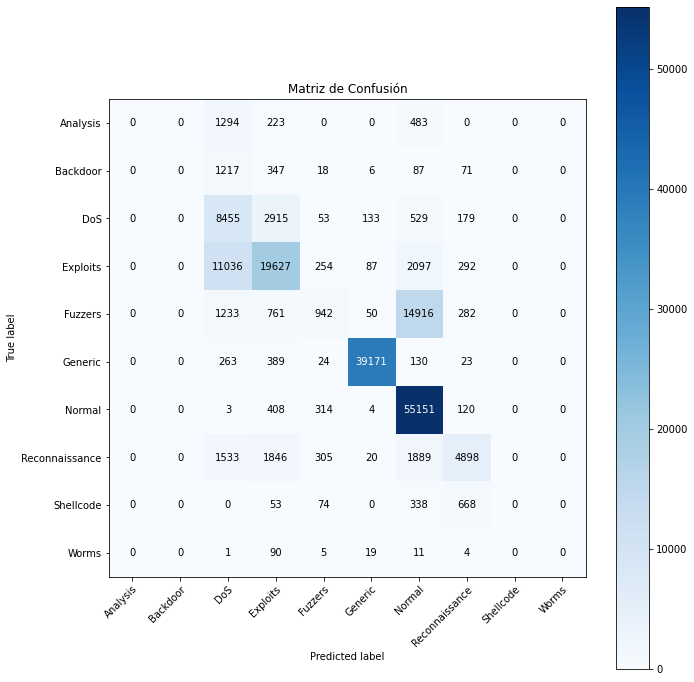

In [24]:
y_test_un=np.argmax(y_test, axis=1)

plot_confusion_matrix(y_true=y_test_un, y_pred=y_pred, classes=onehot.columns,
                      title='Matriz de Confusión')

print(classification_report(y_test_un, y_pred, target_names=onehot.columns))